In [ ]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 4]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi
from scipy.linalg import cholesky, eigh
from composites import isotropic_plate

from tudaesasII.quad4r import Quad4R, update_K, update_M, DOF

def mag2db(mag):
    return 20*np.log10(mag)

nx = 25
ny = 25

a = 0.300 # [m]
b = 0.274 # [m]

E = 70.e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
h = 0.001 # m

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

plate = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True)

N = DOF*nx*ny
K = np.zeros((N, N))
M = np.zeros((N, N))
quads = []

for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)
    assert normal > 0 # guaranteeing that all elements have CCW positive normal
    quad = Quad4R()
    quad.rho = rho
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.scf13 = plate.scf_k13
    quad.scf23 = plate.scf_k23
    quad.h = h
    quad.A = plate.A
    quad.B = plate.B
    quad.D = plate.D
    quad.Atrans = plate.Atrans
    update_K(quad, nid_pos, ncoords, K)
    update_M(quad, nid_pos, ncoords, M)
    quads.append(quad)

bk = np.zeros(N, dtype=bool) # constrained DOFs, can be used to prescribe displacements
# eliminating u and v
bk[0::DOF] = True
bk[1::DOF] = True

# unknown DOFs
bu = ~bk

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]

L = cholesky(Muu, lower=True)
Linv = np.linalg.inv(L)
Ktilde = Linv @ Kuu @ Linv.T

rbmodes = 3
Nmodes = 40
gamma, V = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
V = V[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

P = V


zeta = 0.02

omegad = omegan*np.sqrt(1 - zeta**2)

print('omegan [Hz]', omegan/(2*pi))
print('omegad [Hz]', omegad/(2*pi))


C:\Users\jsodja\AppData\Local\Temp\ipykernel_24580\546060620.py:95: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  gamma, V = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1


omegan [Hz] [  39.82098356   56.39798301   76.19418087  100.81410827  107.74792239
  170.00969065  192.84449539  203.09422909  204.0272206   242.78940932
  316.55557546  331.45588464  335.3404218   379.00755446  404.54091414
  437.09523706  478.08636088  491.35945692  543.60231822  567.43132906
  604.25067606  609.72589846  668.2366702   684.65338194  698.54193271
  716.1898243   734.67081638  820.99225157  864.17651855  909.837361
  918.4057666   927.73211764 1000.03761721 1026.21260285 1051.55219826
 1071.92398486 1191.97518144]
omegad [Hz] [  39.81301857   56.38670229   76.17894051  100.79394344  107.72637065
  169.97568531  192.80592263  203.05360618  203.98641107  242.74084659
  316.49225802  331.38958683  335.27334701  378.93174537  404.45999786
  437.00780927  477.99073405  491.2611752   543.49358689  567.31783144
  604.12981384  609.60394109  668.1030095   684.51643757  698.40221035
  716.04657201  734.52386752  820.82803669  864.00366596  909.65537533
  918.22206707  927.54655

Hammer Impact Parameters
---

In [13]:
tmax = 2
time_steps = 2**16

t = np.linspace(0, tmax, time_steps)
dt = t[1] - t[0]

xpos = np.linspace(0, a, 5)
ypos = np.linspace(0, b, 5)
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten()
ypos = ypos.flatten()
points = dict(zip(np.arange(1, 26), np.vstack((xpos, ypos)).T))
usedpoints = list(points.keys())

hammer = np.zeros_like(t)
impulse = 5*0.003
print('impulse', impulse)
hammer[:2] = -impulse/dt

impulse 0.015


Simulating Impact Hammer Test
---

omega1 39.8209835649645
omega1 56.39798301094209
omega1 76.19418087141307
omega1 100.81410827475243
omega1 107.74792239435658
omega1 170.0096906507815
omega1 192.8444953890673
omega1 203.09422908611384
omega1 204.02722059869032
omega1 242.78940932473157


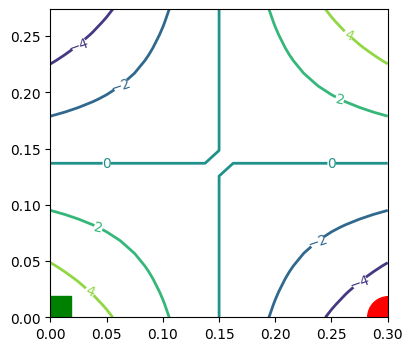

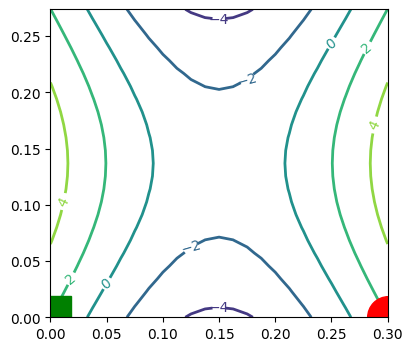

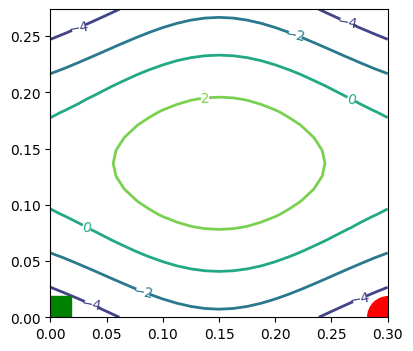

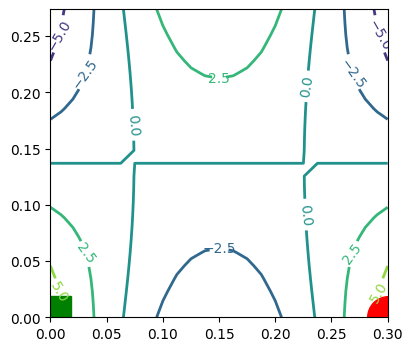

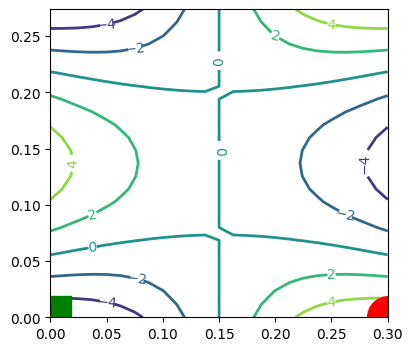

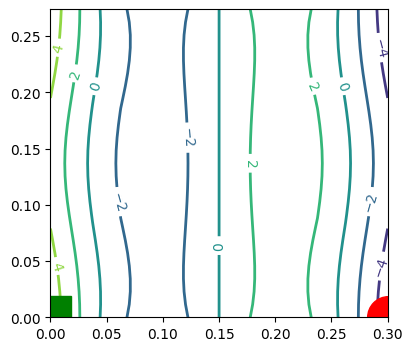

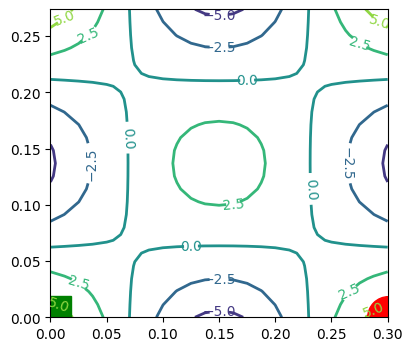

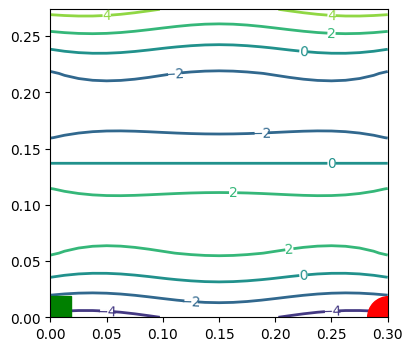

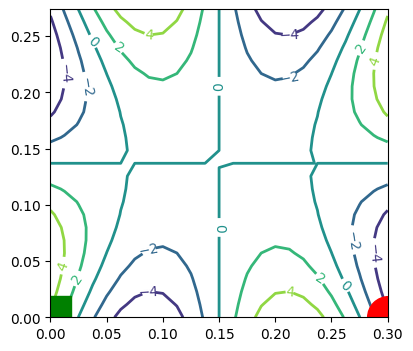

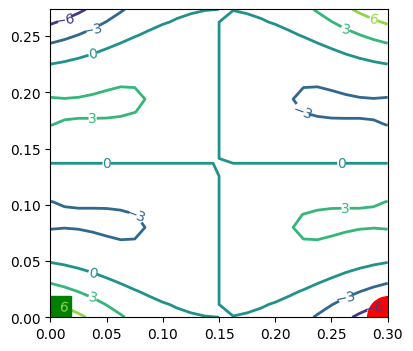

In [14]:
for mode in range(10):
    plt.figure()
    Uu = (Linv.T @ V[:, mode])
    U = np.zeros(K.shape[0])
    U[bu] = Uu
    ax = plt.gca()
    cs = ax.contour(xmesh, ymesh, U[2::DOF].reshape(xmesh.shape).T, levels=5)
    ax.clabel(cs, inline=1, fontsize=10)
    plt.gca().set_aspect('equal')
    print('omega1', omegan[mode]/(2*pi))

    acc_pos = np.where(np.isclose(x, a) & np.isclose(y, 0))[0][0]
    plt.plot(x[acc_pos], y[acc_pos], 'ro', ms=30)
    plt.plot(points[1][0], points[1][0], 'gs', ms=30)

In [15]:
Nsamples = t.size
print('Nsamples', Nsamples)

# dynamic analysis

# initial conditions
v0 = np.zeros(N)
u0 = np.zeros(N)

# modal space
r0 = P.T @ L.T @ u0[bu]
rdot0 = P.T @ L.T @ v0[bu]
phi = np.zeros(Nmodes-rbmodes)
check = r0 != 0
phi[check] = np.arctan(omegad[check]*r0[check]/(zeta*omegan[check]*r0[check] + rdot0[check]))
A0 = np.sqrt(r0**2 + (zeta*omegan/omegad*r0 + rdot0/omegad)**2)

on = omegan[:, None]
od = omegad[:, None]

# convolution integral: general load as a sequence of impulse loads
def r_t(t, t1, t2, on, zeta, od, fmodaln):
    tn = (t1 + t2)/2
    # damped function
    H = np.heaviside(t - tn, 1.)
    h = np.zeros((Nmodes-rbmodes, t.shape[0]))
    check = t >= tn
    h[:, check] = 1/od*np.exp(-zeta*on*(t[check] - tn))*np.sin(od*(t[check] - tn))*H[check]
    return fmodaln*dt*h

# homogeneous solution
rh = A0[:, None]*np.exp(-zeta*on*t)*np.sin(od*t + phi[:, None])

f = np.zeros(N)

responses = {}
u = np.zeros((N, len(t)))
for point in usedpoints:
    ximpact, yimpact = points[point]
    print('analysing impact at point %d:' % point, ximpact, yimpact)
    force_pos = np.where(np.isclose(x, ximpact) & np.isclose(y, yimpact))[0][0]
    
    f[:] = 0
    f[DOF*force_pos+2] += hammer[0]
       
    # calculating modal forces
    fmodaln = (P.T @ Linv @ f[bu])[:, None]

    # convolution
    rpc = r_t(t, 0, 0, on, zeta, od, fmodaln)

    # superposition between homogeneous solution and forced solution
    r = rh + rpc

    # transforming from r-space to displacement
    u[bu] = Linv.T @ P @ r
    responses[point] = u[DOF*acc_pos+2].copy()


Nsamples 65536
analysing impact at point 1: 0.0 0.0
analysing impact at point 2: 0.075 0.0
analysing impact at point 3: 0.15 0.0
analysing impact at point 4: 0.22499999999999998 0.0
analysing impact at point 5: 0.3 0.0
analysing impact at point 6: 0.0 0.0685
analysing impact at point 7: 0.075 0.0685
analysing impact at point 8: 0.15 0.0685
analysing impact at point 9: 0.22499999999999998 0.0685
analysing impact at point 10: 0.3 0.0685
analysing impact at point 11: 0.0 0.137
analysing impact at point 12: 0.075 0.137
analysing impact at point 13: 0.15 0.137
analysing impact at point 14: 0.22499999999999998 0.137
analysing impact at point 15: 0.3 0.137
analysing impact at point 16: 0.0 0.20550000000000002
analysing impact at point 17: 0.075 0.20550000000000002
analysing impact at point 18: 0.15 0.20550000000000002
analysing impact at point 19: 0.22499999999999998 0.20550000000000002
analysing impact at point 20: 0.3 0.20550000000000002
analysing impact at point 21: 0.0 0.274
analysing imp

Checking signals in time domain
---

C:\Users\jsodja\AppData\Local\Temp\ipykernel_24580\936781323.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 3))


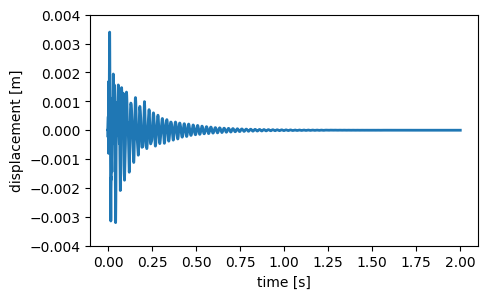

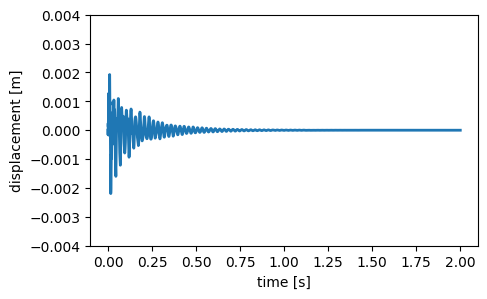

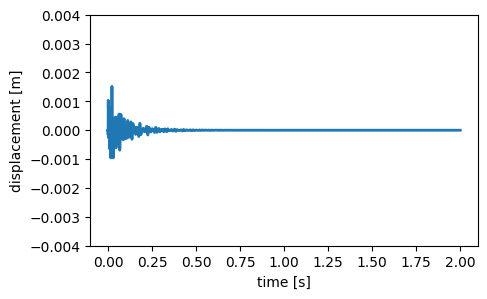

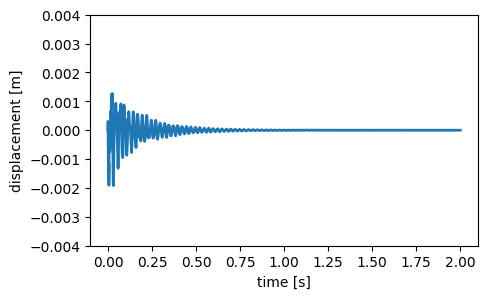

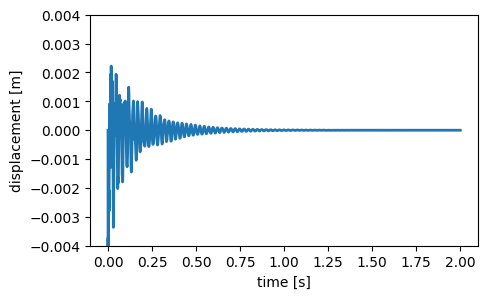

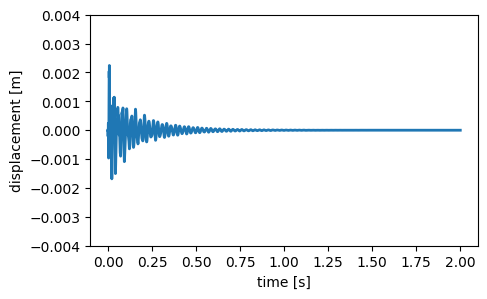

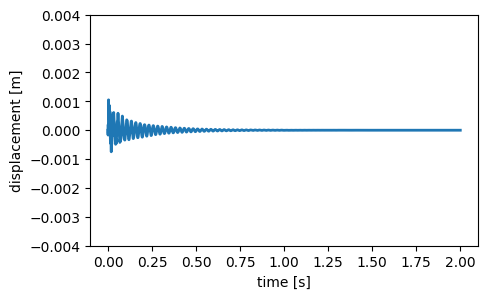

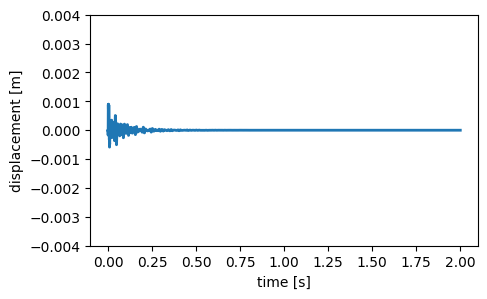

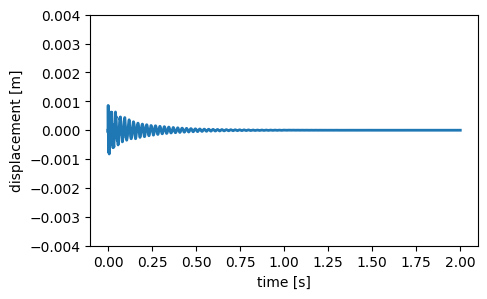

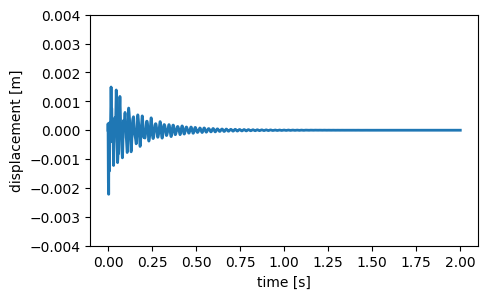

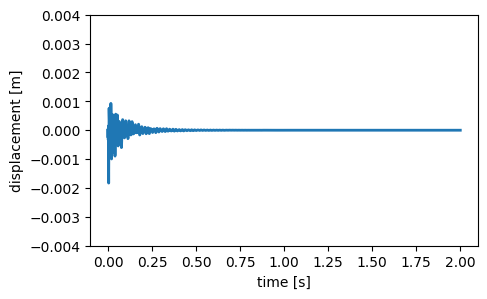

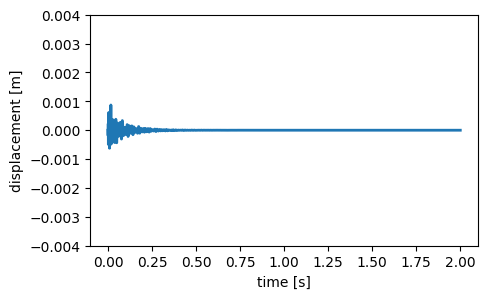

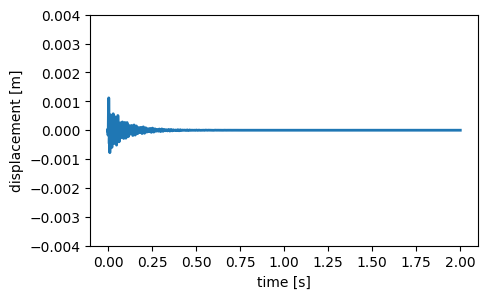

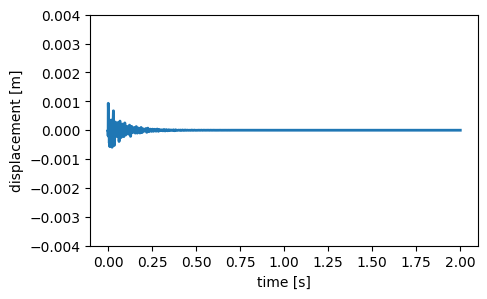

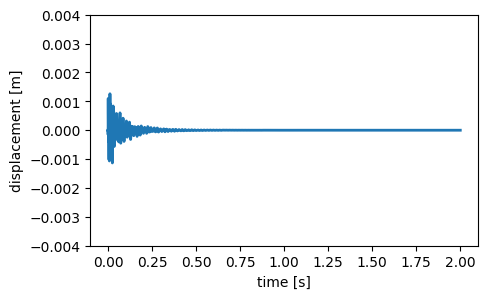

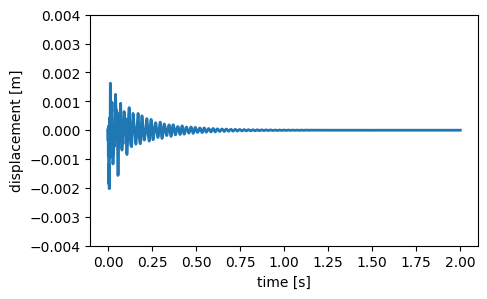

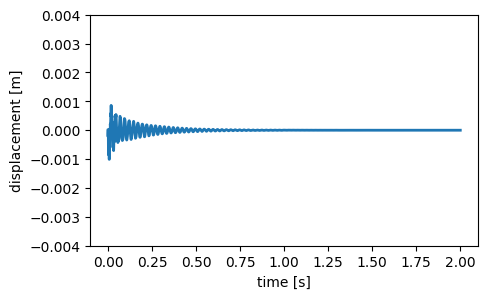

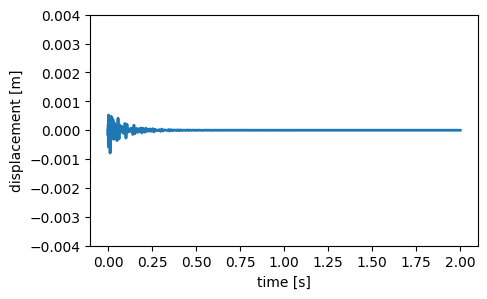

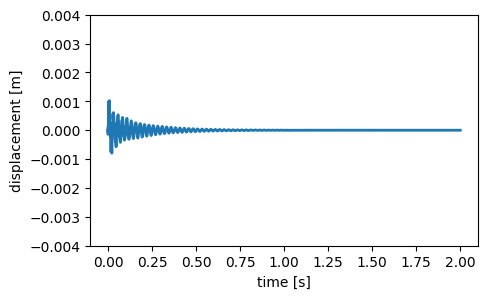

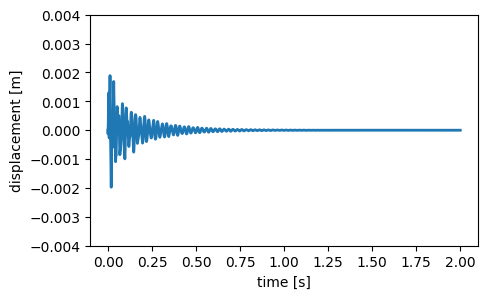

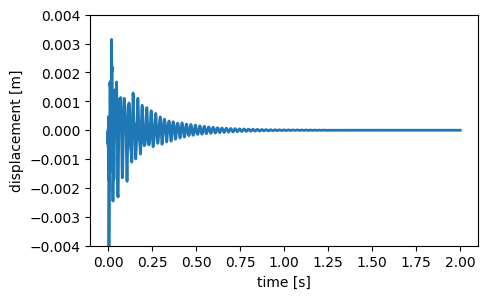

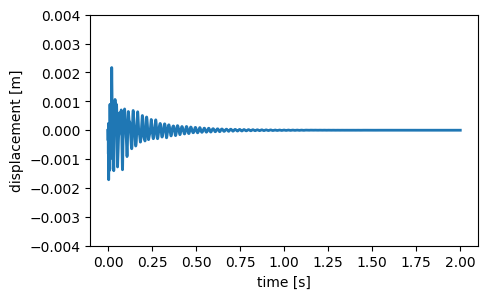

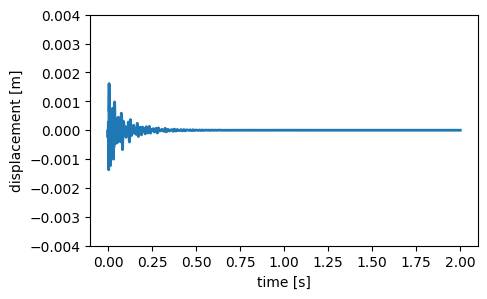

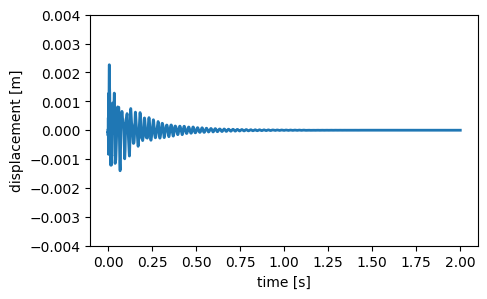

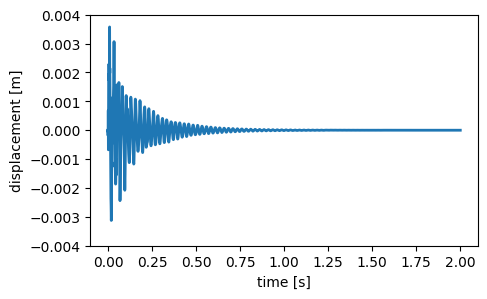

In [16]:
for point in usedpoints:
    plt.figure(figsize=(5, 3))
    plt.plot(t, responses[point])
    plt.xlabel('time [s]')
    plt.ylabel('displacement [m]')
    plt.ylim(-0.004, 0.004)

Experimentally Determining Mode Shapes
---

In [17]:
H_points ={}
dt = t[1] - t[0]
freqs = np.fft.rfftfreq(Nsamples, dt)
xf = np.fft.rfft(hammer)/(Nsamples//2)
for point in usedpoints:
    yf = np.fft.rfft(responses[point])/(Nsamples//2)
    pxx = np.conj(xf)*xf 
    pxy = np.conj(xf)*yf 
    H = np.zeros_like(pxx)
    check = ~np.isclose(pxx, 0+0j)
    H[check] = pxy[check]/pxx[check]
    H_points[point] = H

(0.0, 300.0)

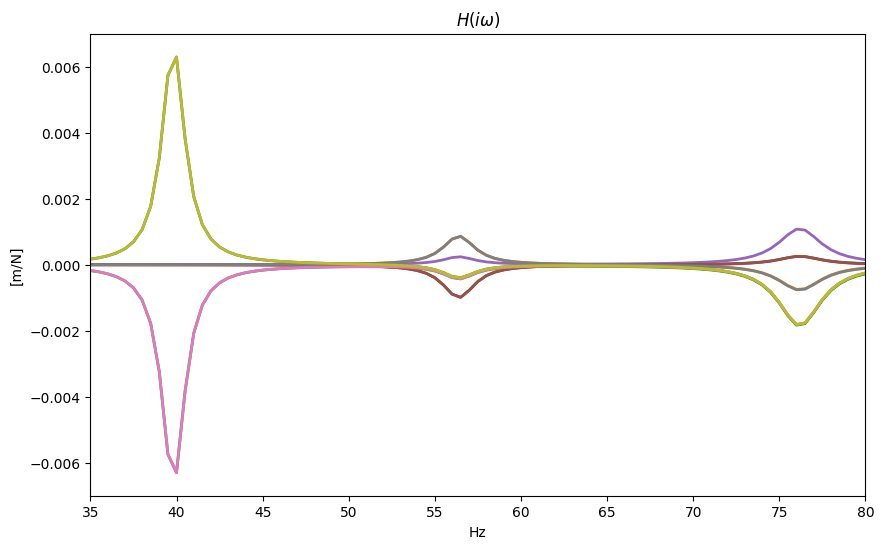

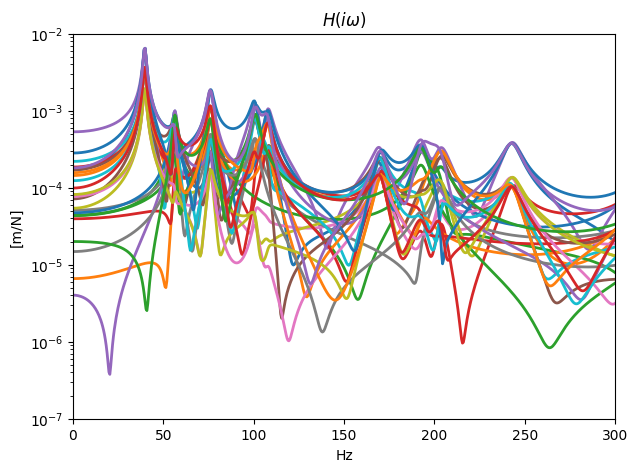

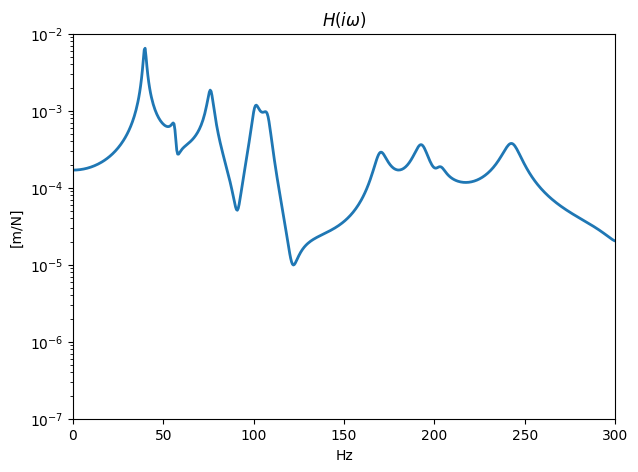

In [28]:
plt.figure(figsize=(10, 6))
for point in [1, 3, 5, 11, 13, 15, 21, 23, 25]:
    H = H_points[point]
    plt.plot(freqs, H.imag)
    plt.xlim(35, 80)
    plt.ylim(-0.007, 0.007)
    plt.title('$H(i\\omega)$')
    plt.xlabel('Hz')
    plt.ylabel('[m/N]')

    
plt.figure(figsize=(7, 5))
for point in usedpoints:
    H = H_points[point]
    plt.semilogy(freqs, np.abs(H))
    plt.xlim(0, 3000)
    plt.ylim(1e-7,1e-2)
    plt.title('$H(i\\omega)$')
    plt.xlabel('Hz')
    plt.ylabel('[m/N]')
plt.xlim(0, 300)


plt.figure(figsize=(7, 5))
H = H_points[1]
plt.semilogy(freqs, np.abs(H))
plt.xlim(0, 300)
plt.ylim(1e-7,1e-2)
plt.title('$H(i\\omega)$')
plt.xlabel('Hz')
plt.ylabel('[m/N]')
plt.xlim(0, 300)

C:\Users\jsodja\AppData\Local\Temp\ipykernel_24580\2465142638.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 3))


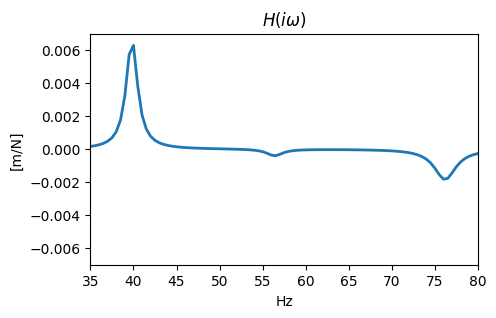

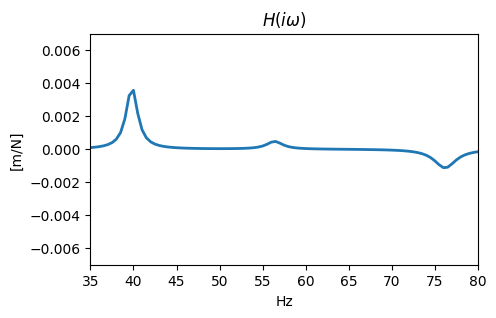

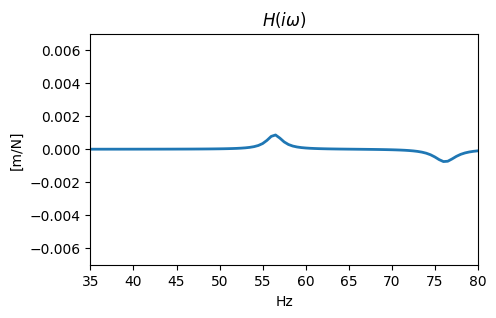

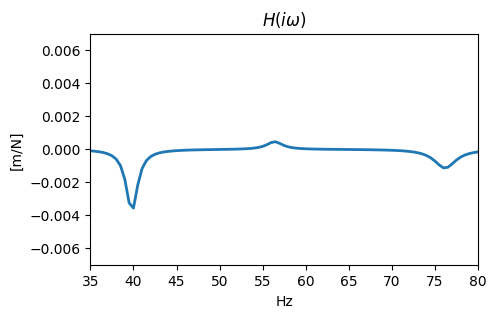

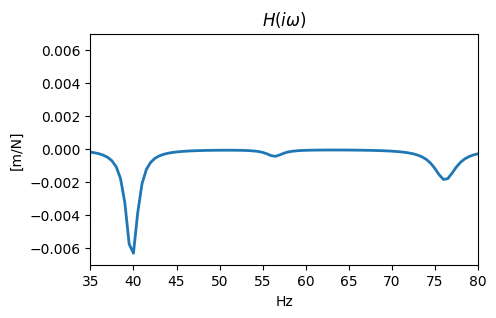

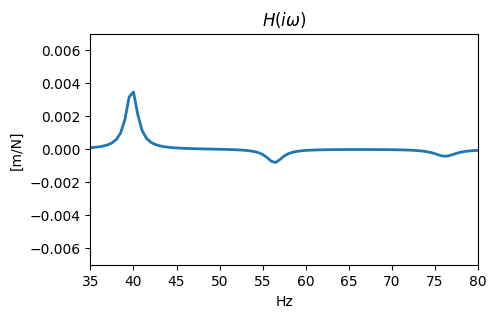

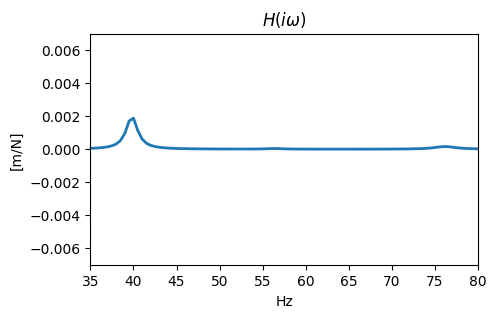

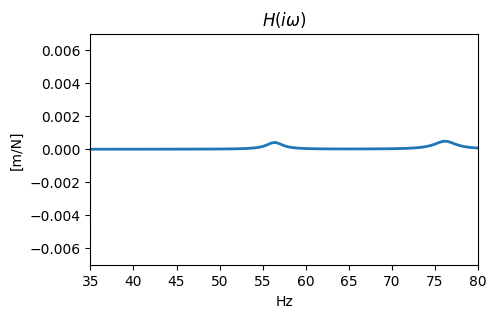

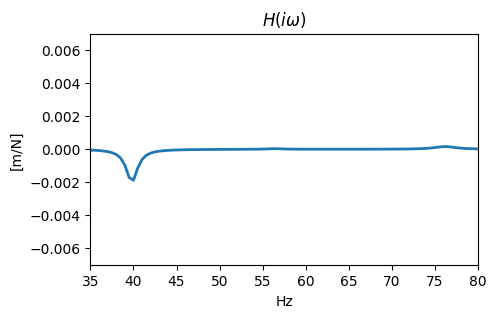

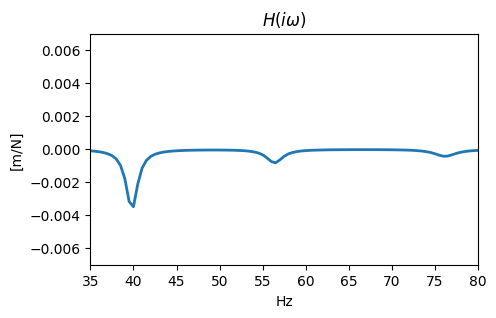

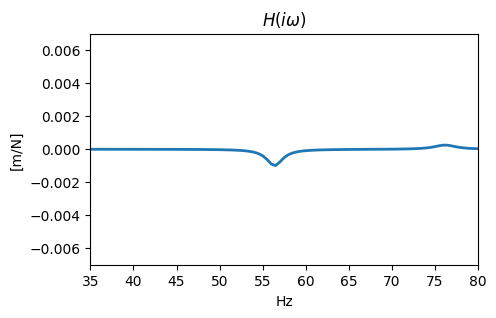

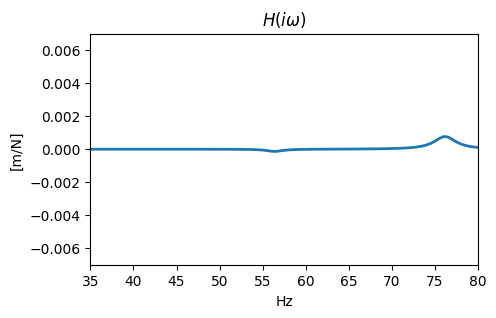

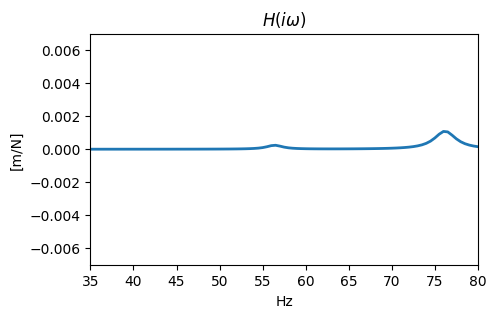

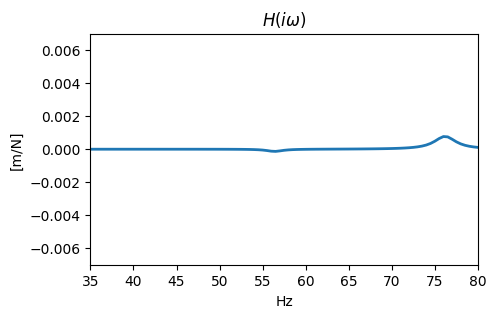

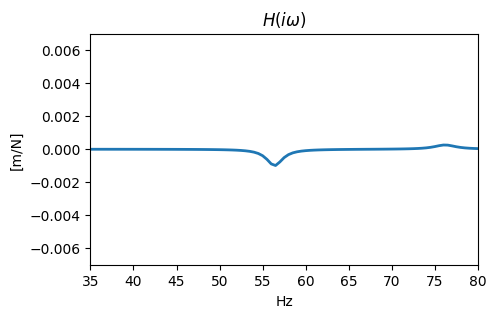

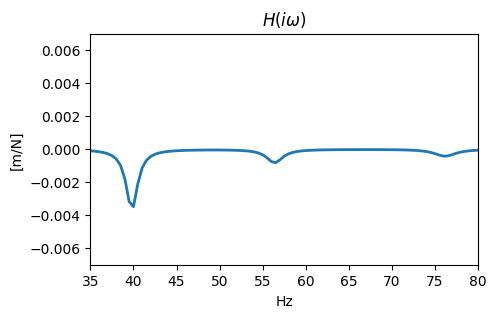

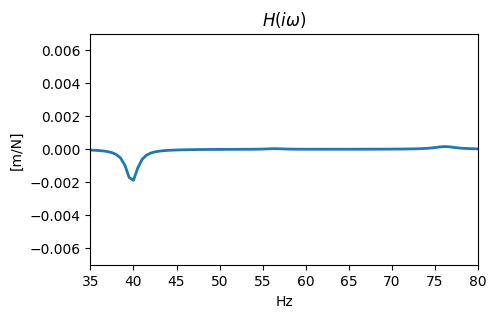

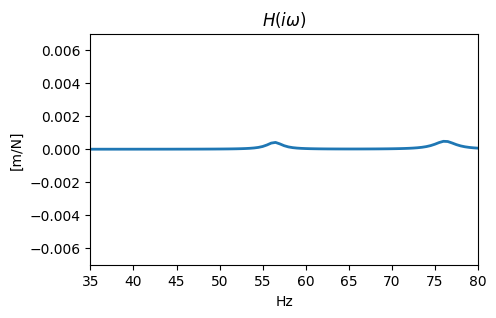

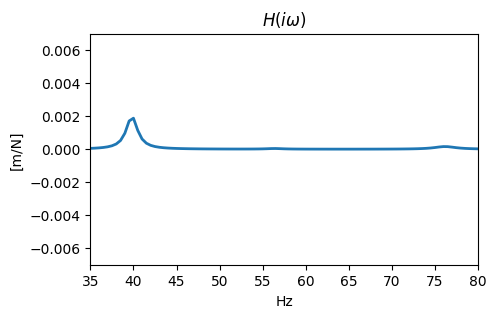

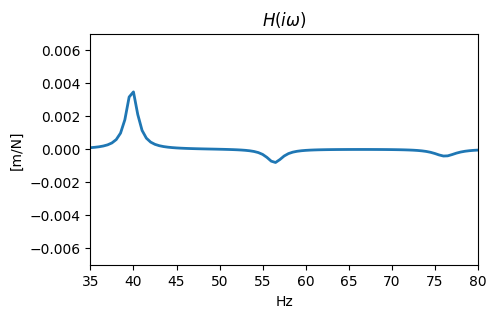

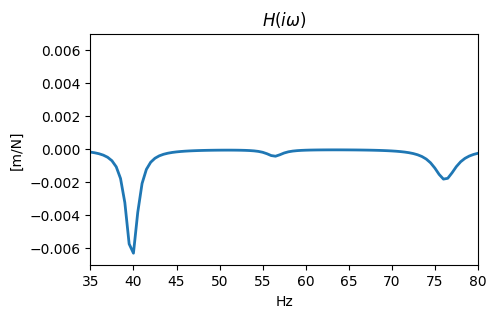

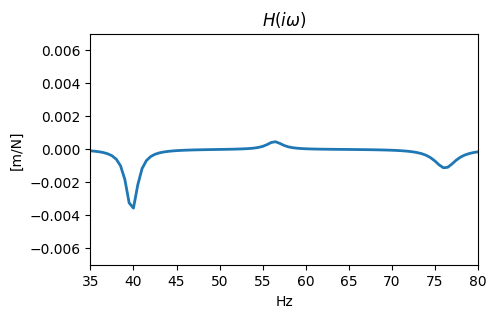

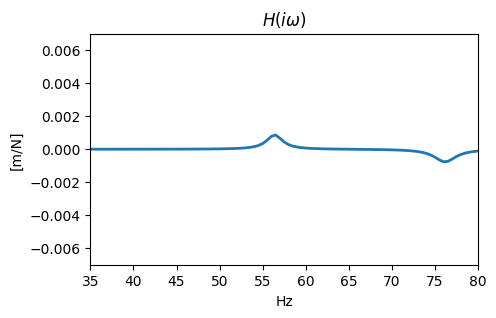

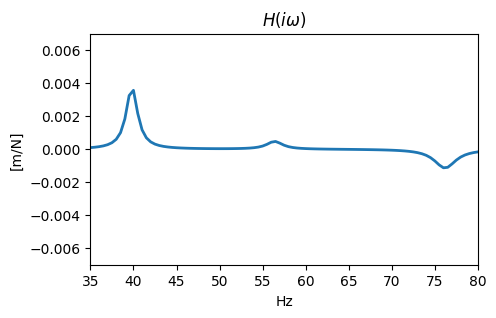

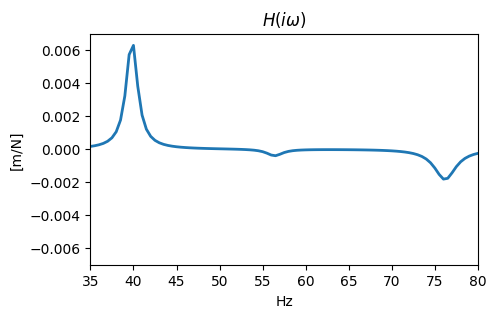

In [29]:
modeshape = []
for point in usedpoints:
    H = H_points[point]
    plt.figure(figsize=(5, 3))
    plt.plot(freqs, H.imag)
    plt.xlim(35, 80)
    plt.ylim(-0.007, 0.007)
    plt.title('$H(i\\omega)$')
    plt.xlabel('Hz')
    plt.ylabel('[m/N]')
    ximpact, yimpact = points[point]
    modeshape.append([point, ximpact, yimpact, H.imag[np.isclose(freqs, omegan[0]/2/pi, rtol=0.01)][0]])

modeshape = np.asarray(modeshape)


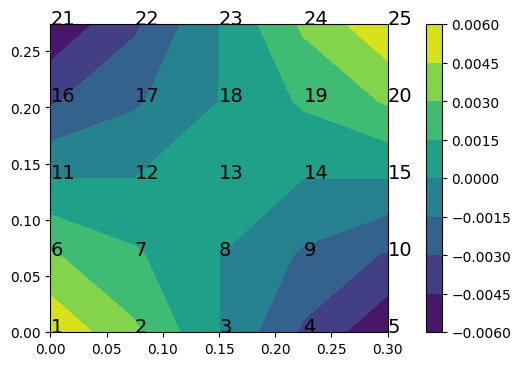

In [31]:
point, ximpact, yimpact, ampl = modeshape.T
plt.contourf(ximpact.reshape(5, 5), yimpact.reshape(5, 5), np.asarray(ampl).reshape(5, 5), levels=10)
for xp, yp, pt in zip(ximpact, yimpact, point):
    plt.text(xp, yp, s=str(int(pt)), fontsize=14)
plt.gca().set_aspect('equal')
plt.colorbar()

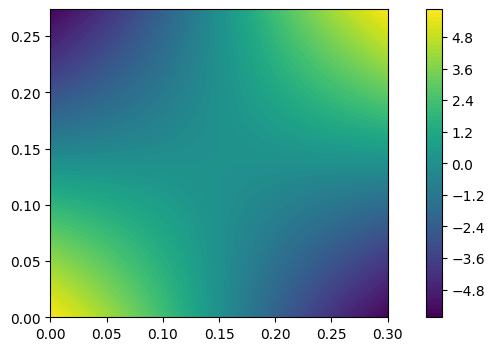

In [32]:
mode = 0
Uu = (Linv.T @ V[:, mode])
U = np.zeros(K.shape[0])
U[bu] = Uu
plt.contourf(xmesh, ymesh, U[2::DOF].reshape(xmesh.shape).T, levels=100)
plt.gca().set_aspect('equal')
plt.colorbar()